In [ ]:
!pip install underthesea

# Khai báo thư viện


In [ ]:
import pandas as pd
from underthesea import word_tokenize
import regex
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf 
from keras_preprocessing import sequence
from keras.models import  Sequential,load_model
from keras.layers import Dense,Embedding,Flatten,GRU,SimpleRNN
from keras.layers import LSTM,Dropout,MaxPool1D,Convolution2D,GlobalMaxPooling1D,Bidirectional
from keras.datasets import imdb
from keras.layers.convolutional import Conv1D,Conv2D
from keras.layers.convolutional import MaxPooling1D
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from keras.losses import categorical_crossentropy

# Load dữ liệu

In [ ]:
data = pd.read_excel('/content/data.xlsx')
data

,Unnamed: 0,Label,Comment
0,0,0,"Shop giao sản phẩm đã qua sử dụng , không hài ..."
1,1,4,"Đóng gói cẩn thận, sp mới và nhỏ gọn. Rất hài ..."
2,2,1,"Sản phẩm nhỏ gọn, giao hàng rất nhanh."
3,3,1,sản phẩm rất chuẩn so vs quảng cáo.
4,4,1,Nhỏ gọn gê
...,...,...,...
26906,995,1,"Sp vô cùng tốt,dùng 2 ngày rưỡi mới hết pin, m..."
26907,996,1,"Máy tốt ,mọi sử dụng không có vân đề gì,nghe n..."
26908,997,1,Chất quá các bro ơi :D Mình thì mua về để đấy ...
26909,998,0,Sản phẩm quá tệ. Pin dùng chưa được 2 ngày đã ...


In [ ]:
data.drop("Unnamed: 0", axis = 1)

,Label,Comment
0,0,"Shop giao sản phẩm đã qua sử dụng , không hài ..."
1,4,"Đóng gói cẩn thận, sp mới và nhỏ gọn. Rất hài ..."
2,1,"Sản phẩm nhỏ gọn, giao hàng rất nhanh."
3,1,sản phẩm rất chuẩn so vs quảng cáo.
4,1,Nhỏ gọn gê
...,...,...
26906,1,"Sp vô cùng tốt,dùng 2 ngày rưỡi mới hết pin, m..."
26907,1,"Máy tốt ,mọi sử dụng không có vân đề gì,nghe n..."
26908,1,Chất quá các bro ơi :D Mình thì mua về để đấy ...
26909,0,Sản phẩm quá tệ. Pin dùng chưa được 2 ngày đã ...


In [ ]:
# các nhãn
set(data['Label'])

{0, 1, 2, 3, 4, 5}

# Xử lý câu


In [ ]:
# hàm xử lí câu
def xuli(cau):
  cau = regex.sub('[.,;/!?#“”$%()^&*-@+=]',' ',cau)
  cau = cau.lower()
  cau = word_tokenize(cau,format='text')
  cau = cau.strip()
  return cau

In [ ]:
for i in range(len(data)):
  data['Comment'][i] = xuli(data['Comment'][i])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Đếm số lần xuất hiện và Visualive

In [ ]:
# Đếm số lần xuất hiện của các từ
count ={}
for i in data['Comment']:
  for j in i.split():
    count[j] = count.get(j,0)+1

In [ ]:
# sắp xếp giảm dần theo value
count = dict(sorted(count.items(), key = lambda x: x[1],reverse=True))

In [ ]:
# Visuallize  
import plotly.graph_objects as go
key = [i for i in count]
value = [count[i] for i in count]
fig = go.Figure(data = [go.Bar(x=key[:50],y=value[:50],text=value[:50])])
fig.update_xaxes(tickangle=40)
fig.show()

# Loại bỏ Stopword

In [ ]:
# Xây dựng stopword là các từ xuất hiện < 3
stopword = [] 
for i in count:
  if count[i]<3:
    stopword.append(i)
len(stopword)

5001

In [ ]:
# Loại bỏ stopword khỏi data
for i in range(len(data)):
  s =''
  sent = data['Comment'][i].split()
  for j in sent:
    if j not in stopword:
      s+= j+' '
  s = s.strip()
  data['Comment'][i] = s

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Xây dựng từ điển

In [ ]:
# tạo vocab
vocab = []
for i in data['Comment']:
  for j in i.split():
    if j not in vocab:
      vocab.append(j)
len(vocab)

5703

In [ ]:
# tạo từ điển
word_id = {}
id_word = {}
dem = 1
for i in vocab:
  word_id[i] = dem
  id_word[dem]=i
  dem+=1

In [ ]:
len(id_word)

5703

In [ ]:
# Hàm chuyển câu thành số
def chuyenCauThanhSo(cau):
  arr = []
  for i in cau.split():
    arr.append(word_id[i])
  return arr

# Tìm câu dài nhất

In [ ]:
# tìm câu dài nhất
max_len = 1
for i in data['Comment']:
  a = len(i.split())
  if a > max_len:
    max_len = a
max_len

624

# Xây dựng data Train model Embedding


In [ ]:
# tạo data train embedding
word_embedding = []
for i in data['Comment']:
    word_embedding.append(i.split())

In [ ]:
print(word_embedding[0])

['shop', 'giao', 'sản_phẩm', 'đã', 'qua', 'sử_dụng', 'không', 'hài_lòng', 'về', 'sản_phẩm']


# Train model Embedding

In [ ]:
# model embedding
model_skip = Word2Vec(word_embedding,window=2,min_count=1,size=300)

In [ ]:
model_skip.most_similar('tệ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('kém', 0.8063895106315613),
 ('tuyệt', 0.7894129753112793),
 ('chán', 0.7794317007064819),
 ('tuyệt_vời', 0.7410296201705933),
 ('hời', 0.7038888335227966),
 ('khó_chịu', 0.699571967124939),
 ('thất_vọng', 0.6922739744186401),
 ('kskskdbdjkskanabaajj', 0.675705075263977),
 ('cầu_kỳ', 0.6749067306518555),
 ('buồn', 0.6728074550628662)]

In [ ]:
model_skip.wv['ngon'].shape

(300,)

In [ ]:
# model_skip.save('/content/drive/MyDrive/NLP/model_skip_300.model')

# Load model embedding và visuallize các từ

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



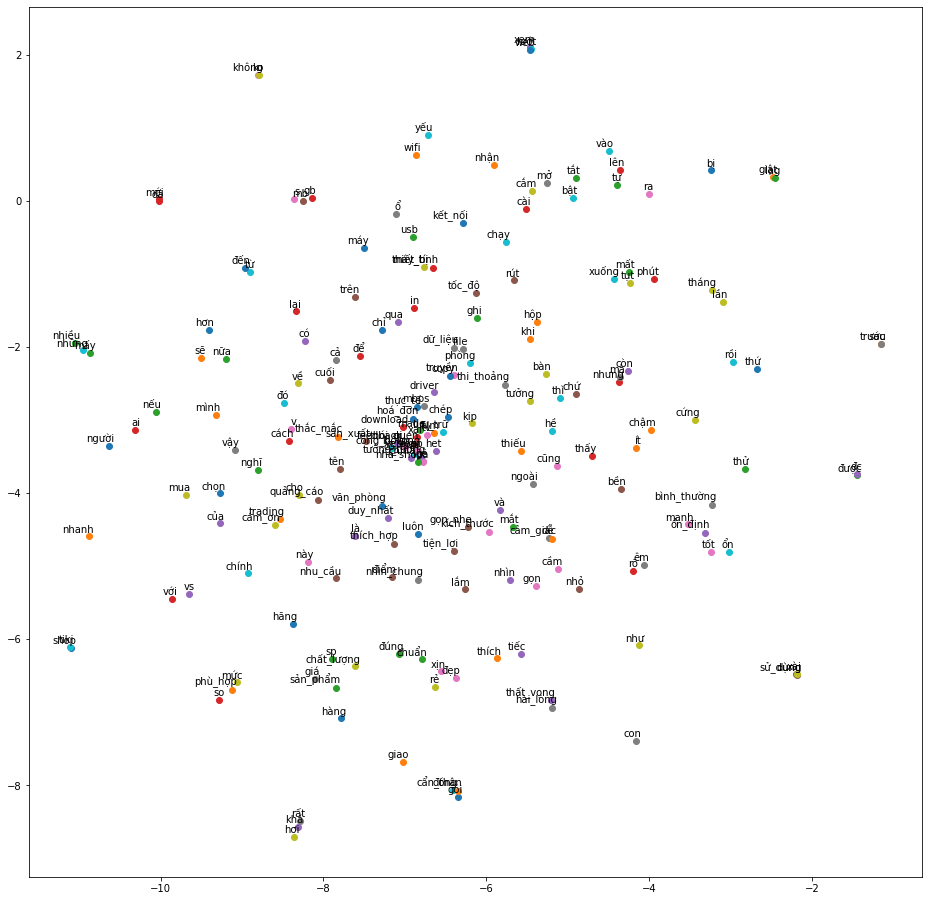

In [ ]:
# load model embedding
model_skip = Word2Vec.load('/content/drive/MyDrive/NLP/model_skip_300.model')


def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in list(model.wv.vocab.keys())[0:200]:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
tsne_plot(model_skip)

# Tạo maxtric Embedding

In [ ]:
# Tạo matrix embedding_matrix chuẩn bị train
embedding_matrix = np.zeros((len(vocab)+1, 300))

for k, v in id_word.items():
    embedding_matrix[k] = model_skip.wv[v]
embedding_matrix.shape

(5704, 300)

# Chuyển câu thành số

In [ ]:
# chuyển câu thành số
x = []
for i in data['Comment']:
  number = chuyenCauThanhSo(i)
  x.append(number)
len(x)

26911

In [ ]:
# padding câu
x = pad_sequences(x,maxlen=max_len,padding='post')

In [ ]:
x

array([[  1,   2,   3, ...,   0,   0,   0],
       [ 10,  11,  12, ...,   0,   0,   0],
       [  3,  16,  17, ...,   0,   0,   0],
       ...,
       [376, 352, 214, ...,   0,   0,   0],
       [  3, 352, 585, ...,   0,   0,   0],
       [533, 622, 227, ...,   0,   0,   0]], dtype=int32)

In [ ]:
# one hot nhãn
y = [i for i in data['Label']]
y =tf.keras.utils.to_categorical(y,num_classes=10)

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)
y_train[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

# Train mô hình

Mô hình 1

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(vocab)+1, output_dim=300, input_length=max_len,weights=[embedding_matrix],trainable=False))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))
print(model.summary())
model.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['acc'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 624, 300)          1711200   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 390       
Total params: 1,939,494
Trainable params: 228,294
Non-trainable params: 1,711,200
_________________________________________________________________
None


In [ ]:
train = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test,y_test))

Mô hình 2

In [ ]:
model2 = Sequential()
model2.add(Embedding(len(vocab)+1, 300, input_length=max_len,weights=[embedding_matrix],trainable=False))
model2.add(Bidirectional(LSTM(64)))
model2.add(Dropout(0.2))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(6, activation='softmax'))
print(model2.summary())
model2.compile(optimizer=Adam(), loss=categorical_crossentropy, metrics=['acc'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 624, 300)          1711200   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               186880    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 198       
Total params: 1,908,614
Trainable params: 197,414
Non-trainable params: 1,711,200
______________________________________

In [ ]:
train2 = model2.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_test,y_test))

Epoch 1/20
169/169 [==============================] - 42s 226ms/step - loss: 1.0625 - acc: 0.6209 - val_loss: 0.8644 - val_acc: 0.6649
Epoch 2/20
169/169 [==============================] - 37s 220ms/step - loss: 0.8275 - acc: 0.6820 - val_loss: 0.8032 - val_acc: 0.6879
Epoch 3/20
169/169 [==============================] - 37s 220ms/step - loss: 0.7837 - acc: 0.6996 - val_loss: 0.7776 - val_acc: 0.6983
Epoch 4/20
169/169 [==============================] - 37s 220ms/step - loss: 0.7595 - acc: 0.7059 - val_loss: 0.7654 - val_acc: 0.6989
Epoch 5/20
169/169 [==============================] - 37s 219ms/step - loss: 0.7425 - acc: 0.7101 - val_loss: 0.7614 - val_acc: 0.6983
Epoch 6/20
169/169 [==============================] - 37s 221ms/step - loss: 0.7241 - acc: 0.7161 - val_loss: 0.7578 - val_acc: 0.6994
Epoch 7/20
169/169 [==============================] - 37s 220ms/step - loss: 0.7061 - acc: 0.7248 - val_loss: 0.7413 - val_acc: 0.7128
Epoch 8/20
169/169 [==============================] - 3

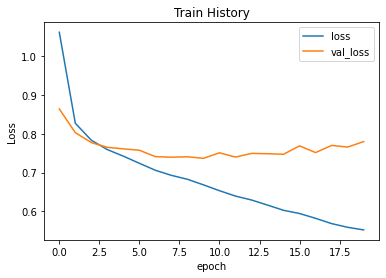

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train2.history['loss'])
plt.plot(train2.history['val_loss'])
plt.title('Train History')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend(['loss','val_loss'])
plt.show()

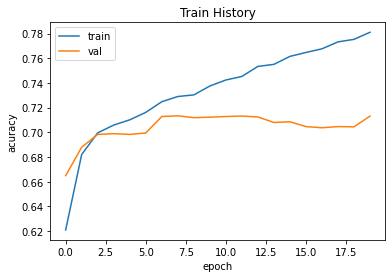

In [ ]:
plt.plot(train2.history['acc'])
plt.plot(train2.history['val_acc'])
plt.title('Train History')
plt.xlabel('epoch')
plt.ylabel('acuracy')
plt.legend(['train','val'])
plt.show()